## Grab NFL data by webscraping

Grab data from here: https://nextgenstats.nfl.com/stats/top-plays/fastest-ball-carriers

Useful glossery for the data: https://nextgenstats.nfl.com/glossary

In [149]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import networkx as nx

In [122]:
#Different variations to explore
stats_division = ["receiving", "rushing", "passing"]
seasons = [2018, 2019, 2020, 2021, 2022, 2023]

In [123]:
#function to grab data for a certain season and stat division
def grabPlayerData(stat, season):
    url = "https://nextgenstats.nfl.com/api/statboard/" + stat + "?season=" + str(season) + "&seasonType=REG"
    referrer = "https://nextgenstats.nfl.com/stats/" + stats_division[2]

    headers = {
        "Accept": "application/json, text/plain, */*",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-US,en;q=0.9",
        "Referer": referrer,
        "Sec-Ch-Ua": "\"Chromium\";v=\"116\", \"Not)A;Brand\";v=\"24\", \"Google Chrome\";v=\"116\"",
        "Sec-Ch-Ua-Mobile": "?0",
        "Sec-Ch-Ua-Platform": "\"macOS\"",
        "Sec-Fetch-Dest": "empty",
        "Sec-Fetch-Mode": "cors",
        "Sec-Fetch-Site": "same-origin",
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
        "X-Override-Env": "true"
    }

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("An error occurred")
    
    json_data = response.json()
    df = pd.DataFrame(json_data['stats'])
    df = df.drop('player', axis=1)

    # Add playerID and other info
    gsisItIds = [item['player']['gsisItId'] for item in json_data['stats']]
    names = [item['player']['displayName'] for item in json_data['stats']]
    positions = [item['player']['position'] for item in json_data['stats']]
    df['playerID'] = gsisItIds
    df['playerName'] = names #espeically useful for running backs who do not have this information by default
    df['position'] = positions

    return df

In [124]:
#function to get the past 6 years worth of data relation to certain statistic division
def grabAllPlayerData(stat):
    full_df = pd.DataFrame()
    for season in seasons:
        newDf = grabPlayerData(stat, season)
        newDf["season"] = season
        if full_df.empty:
            full_df = newDf
        else:
            full_df = pd.concat([full_df, newDf], axis=0)

    return full_df

In [125]:
#Additionally, make a data frame about NFL teams and their general information
url = "https://nextgenstats.nfl.com/api/league/teams"
referrer = "https://nextgenstats.nfl.com/stats/top-plays/fastest-ball-carriers"

headers = {
    "Accept": "application/json, text/plain, */*",
    "Accept-Encoding": "gzip, deflate, br",
    "Accept-Language": "en-US,en;q=0.9",
    "Referer": referrer,
    "Sec-Ch-Ua": "\"Chromium\";v=\"116\", \"Not)A;Brand\";v=\"24\", \"Google Chrome\";v=\"116\"",
    "Sec-Ch-Ua-Mobile": "?0",
    "Sec-Ch-Ua-Platform": "\"macOS\"",
    "Sec-Fetch-Dest": "empty",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Site": "same-origin",
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
    "X-Override-Env": "true"
}

response = requests.get(url, headers=headers)
if response.status_code != 200:
    print("An error occurred")
    
json_data = response.json()
teams = pd.DataFrame(json_data)
teams = teams.drop(['conference', 'logo', 'smartId', 'division'], axis=1)
teams

,abbr,cityState,conferenceAbbr,fullName,nick,season,stadiumName,teamId,teamSiteTicketUrl,teamSiteUrl,teamType,ticketPhoneNumber,yearFound,divisionAbbr
0,AFC,AFC Pro Bowl,AFC,AFC Pro Bowl Team,AFC Pro Bowl,2023,Allegiant Stadium,8600,None,None,PRO,None,2020,NaN
1,ARI,Arizona,NFC,Arizona Cardinals,Cardinals,2023,State Farm Stadium,3800,http://www.azcardinals.com/tickets/,http://www.azcardinals.com/,TEAM,602-379-0102,1920,NCW
2,ATL,Atlanta,NFC,Atlanta Falcons,Falcons,2023,Mercedes-Benz Stadium,0200,http://www.atlantafalcons.com/tickets/,http://www.atlantafalcons.com/,TEAM,470-341-4500,1966,NCS
3,BAL,Baltimore,AFC,Baltimore Ravens,Ravens,2023,M&T Bank Stadium,0325,http://www.baltimoreravens.com/tickets/,http://www.baltimoreravens.com/,TEAM,410-261-RAVE (7283),1996,ACN
4,BUF,Buffalo,AFC,Buffalo Bills,Bills,2023,Highmark Stadium,0610,http://www.buffalobills.com/tickets/,http://www.buffalobills.com/,TEAM,877-BB-TICKS,1960,ACE
5,CAR,Carolina,NFC,Carolina Panthers,Panthers,2023,Bank of America Stadium,0750,http://www.panthers.com/tickets/,http://www.panthers.com/,TEAM,800-745-3000,1995,NCS
6,CHI,Chicago,NFC,Chicago Bears,Bears,2023,Soldier Field,0810,http://www.chicagobears.com/tickets/,http://www.chicagobears.com/,TEAM,888-79-BEARS,1920,NCN
7,CIN,Cincinnati,AFC,Cincinnati Bengals,Bengals,2023,Paycor Stadium,0920,http://www.bengals.com/tickets/,http://www.bengals.com/,TEAM,866-621-TDTD (8383),1968,ACN
8,CLE,Cleveland,AFC,Cleveland Browns,Browns,2023,Cleveland Browns Stadium,1050,http://www.clevelandbrowns.com/tickets/,http://www.clevelandbrowns.com/,TEAM,440-824-3434,1946,ACN
9,DAL,Dallas,NFC,Dallas Cowboys,Cowboys,2023,AT&T Stadium,1200,http://www.dallascowboys.com/tickets/index.html,http://www.dallascowboys.com/,TEAM,817-892-5000,1960,NCE


In [126]:
#Choose stats values to look: 0:receieving, 1:rushing, 2:passing
stat_receiving = stats_division[0]
stat_rushing = stats_division[1]
stat_passing = stats_division[2]

receiving = grabAllPlayerData(stat_receiving)
rushing = grabAllPlayerData(stat_rushing)
passing = grabAllPlayerData(stat_passing)

In [127]:
receiving

,avgCushion,avgExpectedYAC,avgIntendedAirYards,avgSeparation,avgYAC,avgYACAboveExpectation,catchPercentage,percentShareOfIntendedAirYards,recTouchdowns,receptions,targets,yards,playerName,position,teamId,playerID,season
0,7.490600,4.231568,12.904038,3.012981,4.755172,0.523604,55.769231,13.654206,5,29,52,402,Josh Reynolds,WR,2510,44930,2018
1,7.337778,4.299775,19.107703,2.736570,4.554634,0.254860,55.405405,21.423041,4,41,74,774,DeSean Jackson,WR,4900,33130,2018
2,7.127455,4.216796,13.158929,3.222743,4.674865,0.458069,66.071429,23.001960,1,37,56,466,Taywan Taylor,WR,2100,44884,2018
3,6.972651,3.832634,11.038495,3.467761,3.563284,-0.269350,72.043011,23.005470,2,67,93,688,Taylor Gabriel,WR,0810,42016,2018
4,6.727692,2.545114,12.164462,2.419483,2.931026,0.385912,60.000000,19.152271,5,39,65,494,Curtis Samuel,WR,0750,44852,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,4.887429,3.689494,10.768286,2.478195,4.586000,0.896506,57.142857,16.408709,2,20,35,258,Odell Beckham,WR,0325,41238,2023
121,4.861515,3.965850,6.933878,3.207864,5.497778,1.531928,73.469388,14.292806,1,36,49,418,Trey McBride,TE,3800,54520,2023
122,4.852000,3.478894,10.343200,1.870734,3.426000,-0.052894,60.000000,10.122767,0,15,25,158,DeVante Parker,WR,3200,42357,2023
123,4.725789,3.933900,7.697143,3.763452,4.200667,0.266766,53.571429,8.429188,1,15,28,102,Dawson Knox,TE,0610,47879,2023


In [128]:
rushing

,avgTimeToLos,expectedRushYards,rushAttempts,rushPctOverExpected,rushTouchdowns,rushYards,rushYardsOverExpected,rushYardsOverExpectedPerAtt,teamId,efficiency,percentAttemptsGteEightDefenders,avgRushYards,playerID,playerName,position,season
0,2.778851,434.326871,115,0.368421,1,385,-53.326871,-0.467780,0610,4.611351,20.869565,3.347826,36052,Chris Ivory,RB,2018
1,2.802581,527.683722,140,0.391304,6,578,37.316278,0.270408,3000,3.756298,27.857143,4.128571,40129,Latavius Murray,RB,2018
2,2.816724,581.078076,155,0.341935,1,517,-64.078076,-0.413407,2100,4.576228,25.806452,3.335484,37224,Dion Lewis,RB,2018
3,2.764691,405.525111,87,0.390805,3,364,-41.525111,-0.477300,3700,3.872555,6.896552,4.183908,43442,Wendell Smallwood,RB,2018
4,2.954226,764.579411,192,0.352941,8,996,192.420589,1.028987,1050,3.478876,33.854167,5.187500,46104,Nick Chubb,RB,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,2.479576,333.756211,94,0.457447,1,351,17.243789,0.183445,0750,3.572536,17.021277,3.734043,53555,Chuba Hubbard,RB,2023
42,2.959768,273.105746,60,0.389831,3,258,-18.105746,-0.306877,0325,4.137752,5.000000,4.300000,47896,Justice Hill,RB,2023
43,2.726935,619.686715,160,0.377358,7,618,-7.686715,-0.048344,2250,3.808204,24.375000,3.862500,53454,Travis Etienne,RB,2023
44,2.771008,501.023737,139,0.407407,1,568,53.976263,0.399824,3410,3.680669,17.985612,4.086331,46071,Saquon Barkley,RB,2023


In [129]:
passing

,aggressiveness,attempts,avgAirDistance,avgAirYardsDifferential,avgAirYardsToSticks,avgCompletedAirYards,avgIntendedAirYards,avgTimeToThrow,completionPercentage,completionPercentageAboveExpectation,...,maxCompletedAirDistance,passTouchdowns,passYards,passerRating,playerName,season,seasonType,position,teamId,playerID
0,20.370370,378,22.527064,-2.423830,1.558223,8.431475,10.855305,2.801374,64.550265,2.164665,...,54.845387,19,2992,90.178571,Jameis Winston,2018,REG,QB,4900,42344
1,17.682927,328,20.419067,-2.373537,-0.912831,5.695171,8.068708,2.789764,62.500000,0.614947,...,48.934520,10,2180,85.670732,Alex Smith,2018,REG,QB,5110,29819
2,17.197452,471,21.049675,-2.061380,-1.672077,5.039562,7.100942,2.693276,67.940552,2.981674,...,40.482157,24,3395,94.218861,Cam Newton,2018,REG,QB,0750,37074
3,13.735343,597,23.270196,-2.812092,-0.164319,5.983253,8.795345,2.949667,62.311558,-1.041831,...,61.410319,25,4442,97.574679,Aaron Rodgers,2018,REG,QB,1800,29851
4,13.859649,570,20.759877,-2.009640,-1.100917,5.644293,7.653933,2.615713,65.789474,-1.562972,...,49.899188,29,4355,97.660819,Tom Brady,2018,REG,QB,3200,25511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,20.666667,300,23.423728,-3.124735,0.489450,6.179148,9.303883,2.801738,58.666667,-5.100817,...,52.550940,14,2009,80.541667,Jordan Love,2023,REG,QB,1800,52434
33,18.750000,288,21.009926,-2.527506,-1.919228,5.034884,7.562390,2.900632,59.722222,-2.124011,...,48.959274,5,1759,75.853588,Zach Wilson,2023,REG,QB,3430,53431
34,13.496933,326,19.524332,-0.975235,-1.925277,5.744439,6.719674,2.695520,68.404908,1.733906,...,57.006754,14,2507,99.054192,Jared Goff,2023,REG,QB,1540,43290
35,11.158798,233,20.144105,-2.110978,-1.368404,5.309351,7.420329,3.028496,66.094421,1.550938,...,60.109654,16,1613,101.743562,Russell Wilson,2023,REG,QB,1400,38605


#### Now have 4 dfs to work with: teams, rushing, passing, receiving

In [130]:
passing.columns

Index(['aggressiveness', 'attempts', 'avgAirDistance',
       'avgAirYardsDifferential', 'avgAirYardsToSticks',
       'avgCompletedAirYards', 'avgIntendedAirYards', 'avgTimeToThrow',
       'completionPercentage', 'completionPercentageAboveExpectation',
       'completions', 'expectedCompletionPercentage', 'gamesPlayed',
       'interceptions', 'maxAirDistance', 'maxCompletedAirDistance',
       'passTouchdowns', 'passYards', 'passerRating', 'playerName', 'season',
       'seasonType', 'position', 'teamId', 'playerID'],
      dtype='object')

In [131]:
#Question: Is Aggressiveness good for a quarterback

In [132]:
#Would hint that its bad
min_attempts = 200
passing_min = passing[passing['attempts'] > min_attempts] #minimum attempts to be included
passing_min[['aggressiveness', 'completionPercentage', 'completionPercentageAboveExpectation', 'interceptions', 'passTouchdowns', 'passYards', 'passerRating']].corr()

,aggressiveness,completionPercentage,completionPercentageAboveExpectation,interceptions,passTouchdowns,passYards,passerRating
aggressiveness,1.000000,-0.259463,0.072758,0.118442,-0.165898,-0.167615,-0.227713
completionPercentage,-0.259463,1.000000,0.796713,-0.199448,0.406922,0.328594,0.774175
completionPercentageAboveExpectation,0.072758,0.796713,1.000000,-0.185357,0.337992,0.229544,0.697018
interceptions,0.118442,-0.199448,-0.185357,1.000000,0.285743,0.455717,-0.270116
passTouchdowns,-0.165898,0.406922,0.337992,0.285743,1.000000,0.861536,0.707730
passYards,-0.167615,0.328594,0.229544,0.455717,0.861536,1.000000,0.491476
passerRating,-0.227713,0.774175,0.697018,-0.270116,0.707730,0.491476,1.000000


In [133]:
qb_stats = passing_min[['playerName', 'season', 'attempts', 'teamId', 'aggressiveness', 'completionPercentage', 'completionPercentageAboveExpectation', 'interceptions', 'passTouchdowns', 'passYards', 'passerRating']]
qb_stats.sort_values('aggressiveness').head(20)

,playerName,season,attempts,teamId,aggressiveness,completionPercentage,completionPercentageAboveExpectation,interceptions,passTouchdowns,passYards,passerRating
29,Patrick Mahomes,2021,658,8600,8.662614,66.261398,-2.403636,13,37,4839,98.454914
35,Justin Fields,2022,318,0810,9.119497,60.377358,-5.526056,11,17,2242,85.180818
36,Bryce Young,2023,290,0750,10.000000,62.758621,-0.444741,7,8,1560,75.933908
18,Patrick Mahomes,2022,648,2310,10.185185,67.129630,-0.680929,12,41,5250,105.156893
16,Patrick Mahomes,2023,334,2310,10.479042,68.562874,-0.855225,8,17,2442,96.669162
19,Jared Goff,2021,494,1540,10.728745,67.206478,1.109743,8,19,3245,91.531714
21,Trevor Lawrence,2022,584,2250,10.787671,66.267123,-0.695598,8,25,4113,95.212614
0,Lamar Jackson,2022,326,0325,11.042945,62.269939,-2.481912,7,17,2242,91.065951
23,Derek Carr,2023,334,3300,11.077844,65.868263,1.309095,4,10,2231,89.795409
25,Russell Wilson,2020,558,4600,11.111111,68.817204,3.917393,13,40,4212,105.070191


In [134]:
qb_stats.sort_values('aggressiveness', ascending=False).head(20)

,playerName,season,attempts,teamId,aggressiveness,completionPercentage,completionPercentageAboveExpectation,interceptions,passTouchdowns,passYards,passerRating
15,Matthew Stafford,2019,291,1540,23.367698,64.261168,3.603000,5,19,2499,106.020905
28,Dwayne Haskins,2019,203,5110,22.660099,58.620690,-4.393744,7,7,1365,76.077586
17,Daniel Jones,2019,459,3410,22.440087,61.873638,0.695084,12,24,3027,87.658860
3,Kenny Pickett,2023,253,3900,22.134387,61.264822,-0.040214,4,6,1616,81.068841
3,Ryan Fitzpatrick,2020,267,2700,21.722846,68.539326,4.896021,8,13,2091,95.575843
23,Josh Rosen,2018,393,3800,21.628499,55.216285,-3.308986,14,11,2278,66.735581
0,Joe Burrow,2020,404,0920,21.534653,65.346535,4.488487,5,13,2688,89.830858
32,Mitchell Trubisky,2020,297,0810,21.212121,67.003367,1.921618,8,16,2055,93.483446
12,Ryan Fitzpatrick,2019,502,2700,20.916335,61.952191,-0.623196,13,20,3529,85.491368
37,Nick Foles,2020,312,0810,20.833333,64.743590,2.385996,8,10,1852,80.769231


/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot:xlabel='aggressiveness', ylabel='passerRating'>

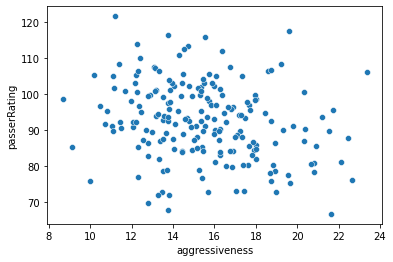

In [135]:
sns.scatterplot(x='aggressiveness', y = 'passerRating', data = qb_stats)

In [136]:
qb_stats['interceptionsPerAttempt'] = qb_stats['interceptions']/qb_stats['attempts']
qb_stats['touchdownsPerAttempt'] = qb_stats['passTouchdowns']/qb_stats['attempts']

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_70745/4241865465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qb_stats['interceptionsPerAttempt'] = qb_stats['interceptions']/qb_stats['attempts']
/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_70745/4241865465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qb_stats['touchdownsPerAttempt'] = qb_stats['passTouchdowns']/qb_stats['attempts']


/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot:xlabel='aggressiveness', ylabel='interceptionsPerAttempt'>

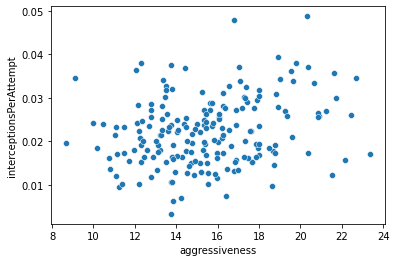

In [137]:
sns.scatterplot(x='aggressiveness', y = 'interceptionsPerAttempt', data = qb_stats)

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot:xlabel='aggressiveness', ylabel='touchdownsPerAttempt'>

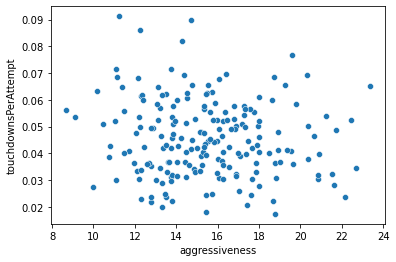

In [138]:
sns.scatterplot(x='aggressiveness', y = 'touchdownsPerAttempt', data = qb_stats)

In [139]:
#Find top/worst season statistics
qb_team = qb_stats.merge(teams, on='teamId')
qb_team = qb_team[["playerName", "season_x", "fullName", "passerRating", "passTouchdowns", "interceptions", "divisionAbbr"]]
qb_team.rename(columns={'season_x': 'season', 'fullName': 'team'}, inplace=True)

In [140]:
qb_team.sort_values("passerRating").head(20)

,playerName,season,team,passerRating,passTouchdowns,interceptions,divisionAbbr
109,Josh Rosen,2018,Arizona Cardinals,66.735581,11,14,NCW
135,Josh Allen,2018,Buffalo Bills,67.890625,10,12,ACE
116,Zach Wilson,2021,New York Jets,69.685596,9,11,ACE
59,Trevor Lawrence,2021,Jacksonville Jaguars,71.857697,12,17,ACS
18,Sam Darnold,2021,Carolina Panthers,71.941708,9,13,NCS
115,Sam Darnold,2020,New York Jets,72.687729,9,11,ACE
117,Zach Wilson,2022,New York Jets,72.813361,6,7,ACE
177,Carson Wentz,2020,Philadelphia Eagles,72.830854,16,15,NCE
9,Dwayne Haskins,2020,Washington Commanders,72.951245,5,7,NCE
82,Justin Fields,2021,Chicago Bears,73.225309,7,10,NCN


In [141]:
qb_team.sort_values("passerRating", ascending=False).head(20)

,playerName,season,team,passerRating,passTouchdowns,interceptions,divisionAbbr
22,Aaron Rodgers,2020,Green Bay Packers,121.530418,48,5,NCN
142,Ryan Tannehill,2019,Tennessee Titans,117.497086,22,6,ACS
92,Drew Brees,2019,New Orleans Saints,116.269841,27,4,NCS
91,Drew Brees,2018,New Orleans Saints,115.682515,32,5,NCS
130,Patrick Mahomes,2018,Kansas City Chiefs,113.843391,50,12,ACW
74,Lamar Jackson,2019,Baltimore Ravens,113.336451,36,6,ACN
183,Deshaun Watson,2020,Houston Texans,112.400429,33,7,ACS
188,Aaron Rodgers,2021,NFC Pro Bowl Team,111.899718,37,4,NaN
164,Russell Wilson,2018,Seattle Seahawks,110.865535,35,7,NCW
90,Brock Purdy,2023,San Francisco 49ers,109.900000,15,5,NCW


### Make a Network

In [178]:
#Network of qbs and teams
G = nx.Graph()

In [179]:
for row in qb_team.itertuples(index=False):
    player = row[0]
    team = row[2]
    division = row[6]

    G.add_node(player, node_type='Player')
    G.add_node(team, node_type='Team')
    G.add_edge(player, team)

G.remove_node("AFC Pro Bowl Team")
G.remove_node("NFC Pro Bowl Team")

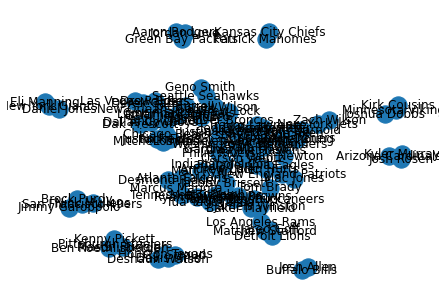

In [180]:
#A little clustered (do better in drawing below)
nx.draw(G,pos=nx.spring_layout(G),with_labels=True)

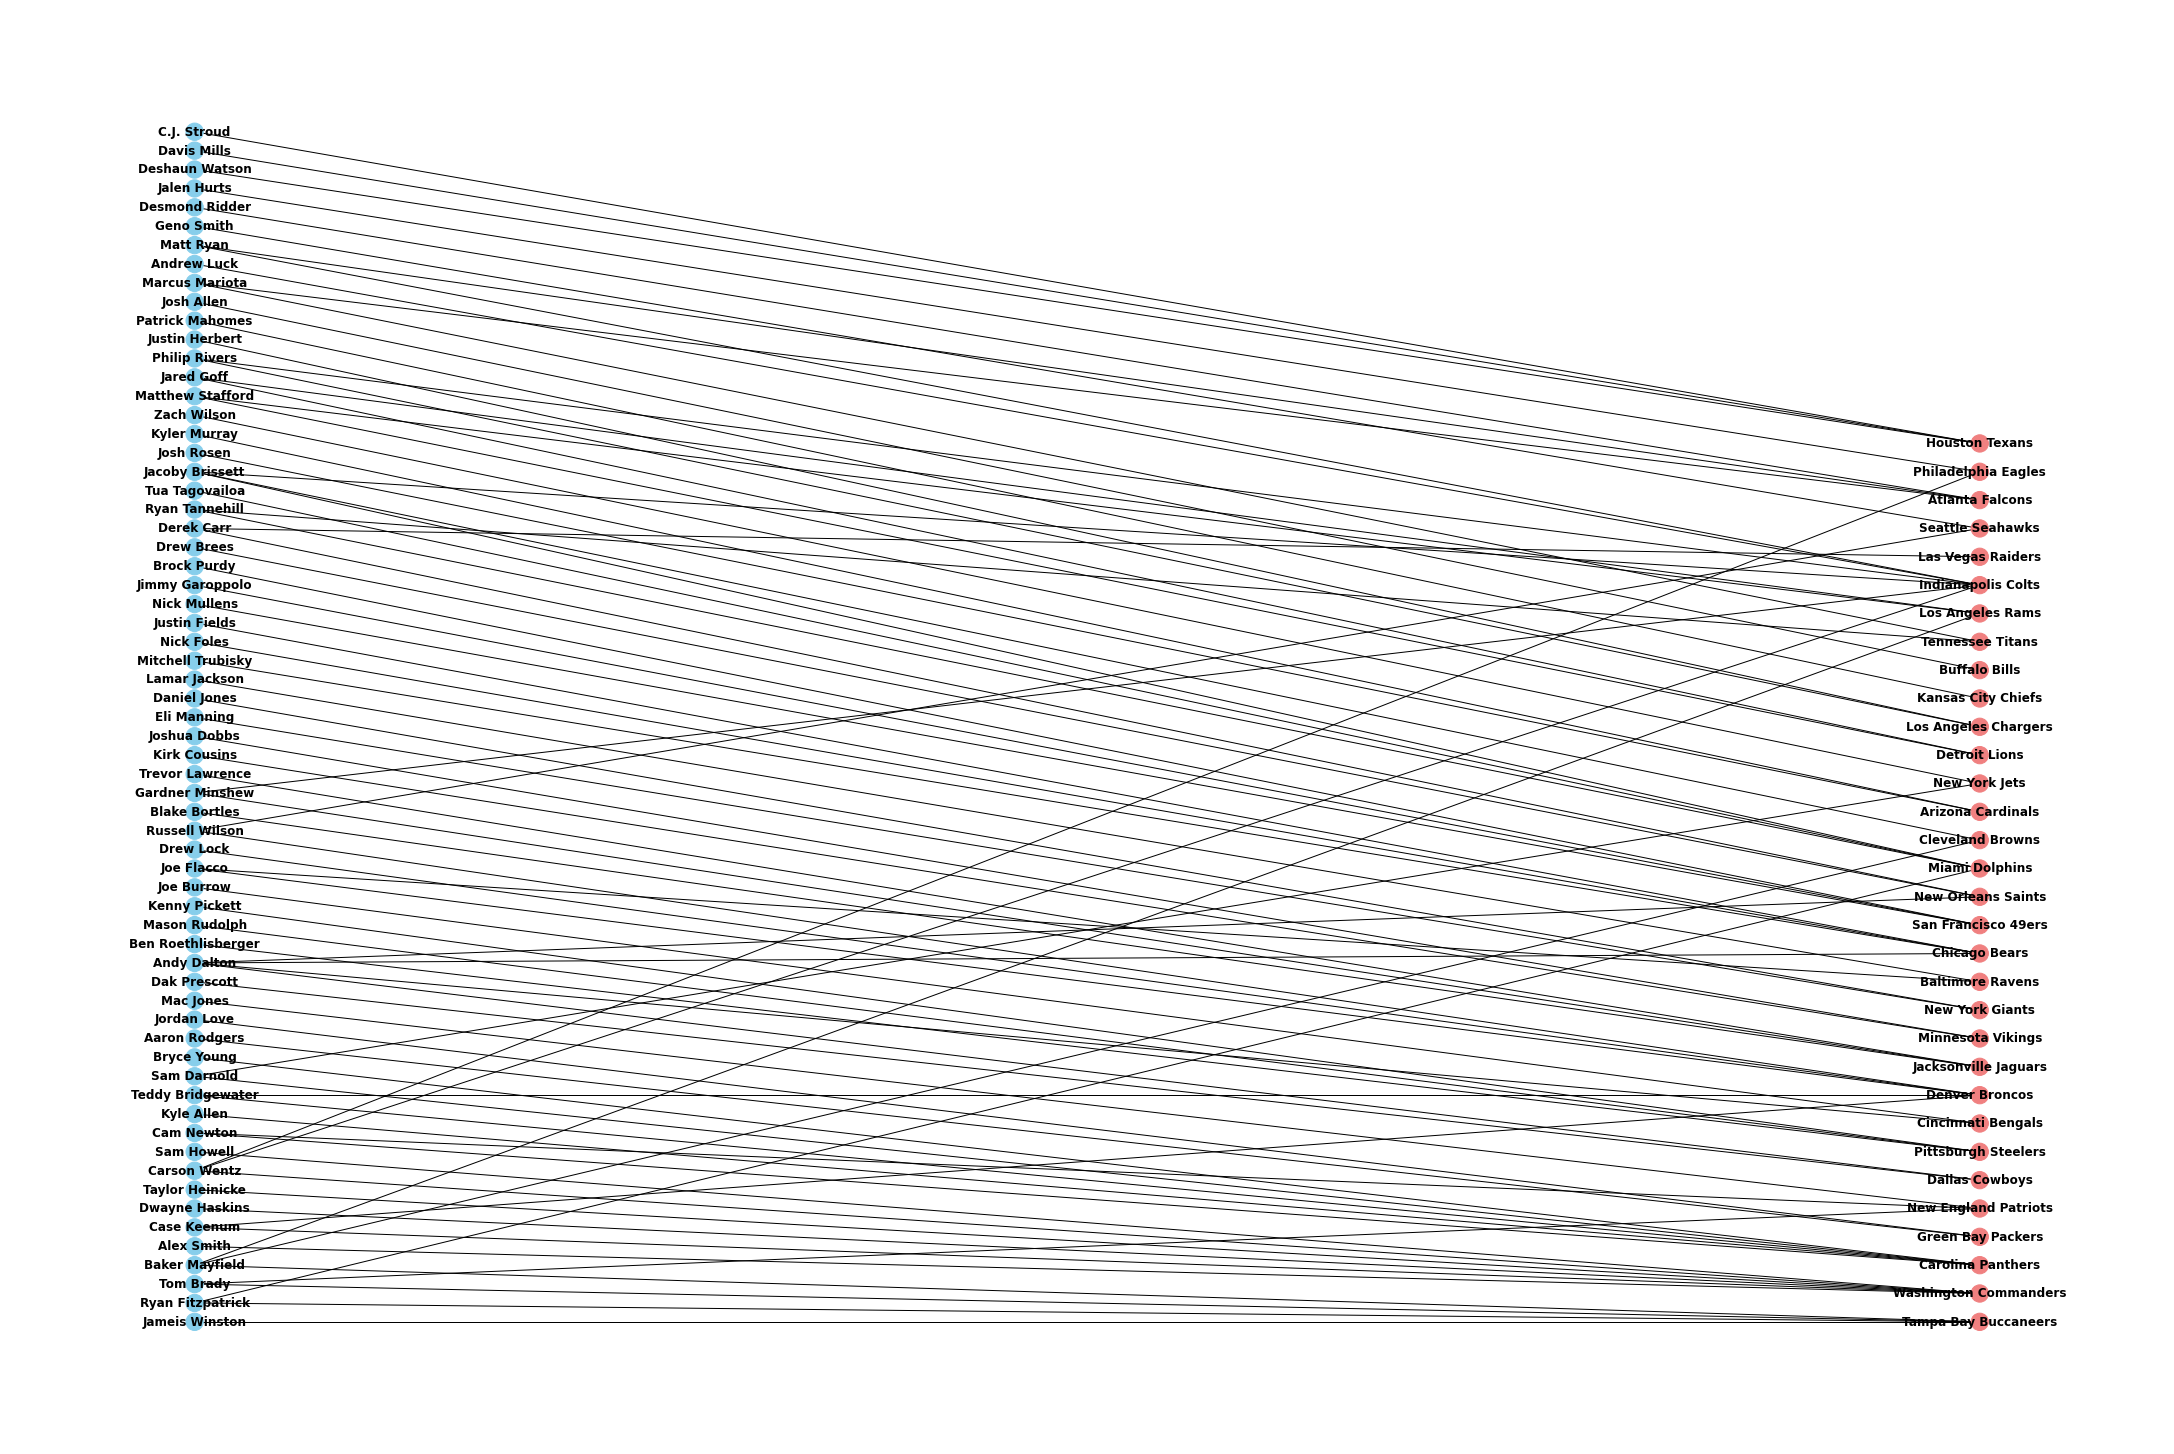

In [192]:
# Get nodes by type
players = [node for node, data in G.nodes(data=True) if data['node_type'] == 'Player']
teams = [node for node, data in G.nodes(data=True) if data['node_type'] == 'Team']

# Calculate spacings based on the number of nodes
player_spacing = 4
team_spacing = 3 * len(players) / len(teams)  # Adjust the factor as needed

# Create a custom layout
pos = {node: (1, player_spacing * i) for i, node in enumerate(players)}
pos.update({node: (2, team_spacing * i) for i, node in enumerate(teams)})

# Set the figure size
plt.figure(figsize=(30, 20))

# Draw the graph
nx.draw(G, pos, with_labels=True, font_size=12, font_color='black', font_weight='bold',
        node_color=['skyblue' if G.nodes[node]['node_type']=='Player' else 'lightcoral' for node in G.nodes])

# Show the plot
plt.show()

In [184]:
G.number_of_edges()

89

In [185]:
G.number_of_nodes()

96

In [186]:
#Find teams with the highest number of neighbors
degrees = dict(G.degree())
max_degree_nodes = [node for node, degree in degrees.items() if degree == max(degrees.values())]
for node in max_degree_nodes:
    print(f"Node: {node}, Degree: {degrees[node]}, Neighbors: {list(G.neighbors(node))}")

Node: Washington Commanders, Degree: 6, Neighbors: ['Alex Smith', 'Case Keenum', 'Dwayne Haskins', 'Taylor Heinicke', 'Carson Wentz', 'Sam Howell']
Node: Indianapolis Colts, Degree: 6, Neighbors: ['Andrew Luck', 'Jacoby Brissett', 'Philip Rivers', 'Carson Wentz', 'Matt Ryan', 'Gardner Minshew']


### Linear Regression

In [143]:
#Linear regression over passing data (autoregression)
#Does Past Success Equal Future Success?

In [144]:
qbs_2020 = qb_team[qb_team['season'] == 2020]
qbs_2021 = qb_team[qb_team['season'] == 2021]

In [145]:
# Sort the DataFrames by 'playerName'
qbs_2020 = qbs_2020.sort_values(by='playerName')
qbs_2021 = qbs_2021.sort_values(by='playerName')

# Perform an inner merge to keep only the players that exist in both DataFrames
merged_qbs = pd.merge(qbs_2020, qbs_2021, on='playerName', suffixes=('_2020', '_2021'), how='inner')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     11.21
Date:                Mon, 13 Nov 2023   Prob (F-statistic):            0.00291
Time:                        02:08:02   Log-Likelihood:                -83.091
No. Observations:                  24   AIC:                             170.2
Df Residuals:                      22   BIC:                             172.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.9600     14.492      3.171      0.0

Text(0, 0.5, 'Residual')

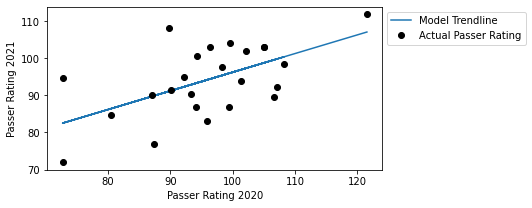

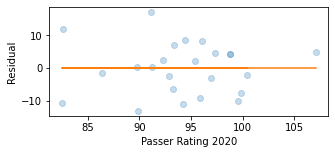

In [196]:
#Run linear regression
x = merged_qbs["passerRating_2020"].to_numpy()
y = merged_qbs["passerRating_2021"].to_numpy()
X = sm.add_constant(x) # add a column of all 1s
model = sm.OLS(y,X) #run OLS
results = model.fit()
print(results.summary())
bhat, ahat = results.params #Grab values
sigma_eps_hat = np.sqrt(results.mse_resid)

# Graph it
fig,ax = plt.subplots(figsize=(6,3))
ax.plot(x,ahat*x + bhat, '-', label="Model Trendline") # graph line of best fit
ax.plot(x,y,"ko",  label="Actual Passer Rating")
ax.set_xlabel("Passer Rating 2020")
ax.set_ylabel("Passer Rating 2021")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

#Graph residuals
r = results.resid
y_mean_pred = y - r
fig,ax = plt.subplots(figsize=(5,2))
ax.plot(y_mean_pred,r,"o", alpha = 0.25)  # Plot the residuals
ax.plot(y_mean_pred,np.zeros(len(y)),"-") # Plot the reference line of 0
ax.set_xlabel("Passer Rating 2020")
ax.set_ylabel("Residual")